# 3.Amazon_SageMaker_DeepAR

This notebook shows how to apply the SageMaker [DeepAR built-in algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNN) to produce both point and probabilistic forecasts.The DeepAR forecasting algorithm can provide better forecast accuracies compared to classical forecasting techniques such as Autoregressive Integrated Moving Average (ARIMA) or Exponential Smoothing (ES), both of which are implemented in many open-source and commercial software packages for forecasting. 

## Table Of Contents
The overall process for this is:

* 1) Setup
* 2) Data Preparation
* 3) Training the DeepAR Model
* 4) Predicting the Model
* 5) Plotting the Prediction

To get started, simply execute the cells below:

## 1) Setup

In [1]:
%store -r

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2) Data Preparation

We will divide our clikstream events by page. In other words, each page has its own clickstream timesereis. We can consider it as separated product sales in retail store. And we will predict the number of clicks in 10 minutes by referring to the number of visitors. To do this, we use the number of clicks as the target feature and the number of users as the dynamic feature.

Change the data to the format that DeepAR algorithm use. The records in your input files should contain the following fields:

* **start** : The start timestamp. A string with the format YYYY-MM-DD HH:MM:SS.
* **target** : An array of floating-point values or integers that represent the time series. Here, we will use clickstream counts in 10 minutes for forecasting value.
* **dynamic_feat (optional)** : An array of arrays of floating-point values or integers that represents the vector of custom feature time series. Here, we will use the number of visitors in 10 minutes for dynamic features.
* **cat (optional)** : An array of categorical features that can be used to encode the groups that the record belongs to. We do not use categorical values in this example.

```python
# example:
{"start": "2012-03-01 00:00:00", "target": [24.0, 22.0, 20.0, 17.0, ...], "dynamic_feat": [[13, 14, 8, ...]]}
```

For more information regarding input/outpot format of DeepAR : https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput


We use variables and dataframes that we stored via `1.Exploratory_Data_Analysis.ipynb` :

In [3]:
training_data = []
for index, url in zip(range(len(urls)), urls):
    agg_click_users = filtered_clickstream[filtered_clickstream['url'] == url].set_index('timestamp').resample('10T')
    clicks = agg_click_users.sum()['clickstream_id']
    users  = agg_click_users.nunique()['user_session_id']
    
    data = {'start' : str(agg_click_users.nunique().index[0]),
            'target': list(clicks.values.astype('float')),
            'dynamic_feat': [list(users.values.astype('float'))]
            }
    training_data.append(data)   

We convert the dict type above into a json file for preparation to train the DeepAR model. *JSON Lines* format is JSON, but with newline-separated records instead of a parent `[... , ...]` array: So a whole JSON Lines file is *not* valid JSON, but each line of the file *is*.

Write our training and test files in JSON Lines, and upload to S3:

In [5]:
import json

def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for row in training_data:
            fp.write(json.dumps(row).encode("utf-8"))
            fp.write("\n".encode('utf-8'))
            
write_dicts_to_file("train.json", training_data)

In [6]:
import sagemaker

sagemaker_session = sagemaker.Session()
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'deepar-clickstream'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

train_s3 = sagemaker_session.upload_data(path='train.json', key_prefix=s3_prefix)
train_s3

's3://sagemaker-us-east-2-322537213286/deepar-clickstream/train.json'

In [7]:
import s3fs

s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(train_s3, 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2012-03-01 00:00:00", "target": [24.0, 22.0, 20.0, 17.0, 15.0, 12.0, 15.0, 10.0, 14.0, 9....


## 3) Training the DeepAR Model

Training a model is almost identical to using any other built-in algorithm. We need to define Estimator with algorhtim and hyperparameters and fit the model with the training data that we prepared above.

Now the useful part - we'll be using the [Python SageMaker SDK](https://sagemaker.readthedocs.io/en/stable/index.html) to:

1. Create our [Estimator](https://sagemaker.readthedocs.io/en/stable/estimators.html) defining the algorithm and fitting/hyper-parameters
2. Define our [data channels](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo-running-container.html#your-algorithms-training-algo-running-container-inputdataconfig) to fit and validate on
3. [Fit](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator.fit) a model to the data

In [9]:
import datetime 

region = sagemaker_session.boto_region_name

# we use 10 minutes frequency for the time series
freq = datetime.timedelta(minutes=10)

# we predict for 24 hours and use same context length with prediction length.
prediction_length = 24 * 6
context_length = 24 * 6

image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [10]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-clickstream'
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Next we need to set some hyperparameters: for example, frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options such as early stopping patience, number of epochs, batch size, and learning rate.

In [11]:
hyperparameters = {
    "time_freq": '10min',
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4"
}
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model. Training will take about 20 minutes in c4.2xlarge instance.

In [15]:
%%time
data_channels = {
    "train": train_s3
}

estimator.fit(data_channels, wait=False)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


CPU times: user 17.3 ms, sys: 0 ns, total: 17.3 ms
Wall time: 158 ms


In [16]:
sagemaker_session.logs_for_job(estimator.latest_training_job.name, wait=True)

2020-08-21 06:14:42 Starting - Starting the training job...
2020-08-21 06:14:43 Starting - Launching requested ML instances......
2020-08-21 06:16:05 Starting - Preparing the instances for training......
2020-08-21 06:17:07 Downloading - Downloading input data
2020-08-21 06:17:07 Training - Downloading the training image...
2020-08-21 06:17:42 Training - Training image download completed. Training in progress..Arguments: train
[08/21/2020 06:17:44 INFO 140166612858688] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'a

[08/21/2020 06:18:03 INFO 140166612858688] Epoch[3] Batch[5] avg_epoch_loss=3.012879
[08/21/2020 06:18:03 INFO 140166612858688] #quality_metric: host=algo-1, epoch=3, batch=5 train loss <loss>=3.01287853718
[08/21/2020 06:18:03 INFO 140166612858688] Epoch[3] Batch [5]#011Speed: 189.38 samples/sec#011loss=3.012879
[08/21/2020 06:18:05 INFO 140166612858688] Epoch[3] Batch[10] avg_epoch_loss=3.025354
[08/21/2020 06:18:05 INFO 140166612858688] #quality_metric: host=algo-1, epoch=3, batch=10 train loss <loss>=3.04032406807
[08/21/2020 06:18:05 INFO 140166612858688] Epoch[3] Batch [10]#011Speed: 190.74 samples/sec#011loss=3.040324
[08/21/2020 06:18:05 INFO 140166612858688] processed a total of 681 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4159.163951873779, "sum": 4159.163951873779, "min": 4159.163951873779}}, "EndTime": 1597990685.427022, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597990681.267796}

[08/21/2020

[08/21/2020 06:18:30 INFO 140166612858688] Saved checkpoint to "/opt/ml/model/state_a6bd2ee4-2b55-4c25-b87f-4e865a6061e0-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 123.6410140991211, "sum": 123.6410140991211, "min": 123.6410140991211}}, "EndTime": 1597990710.211169, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597990710.087031}

[08/21/2020 06:18:30 INFO 140166612858688] Epoch[10] Batch[0] avg_epoch_loss=2.145450
[08/21/2020 06:18:30 INFO 140166612858688] #quality_metric: host=algo-1, epoch=10, batch=0 train loss <loss>=2.14544963837
[08/21/2020 06:18:32 INFO 140166612858688] Epoch[10] Batch[5] avg_epoch_loss=2.160316
[08/21/2020 06:18:32 INFO 140166612858688] #quality_metric: host=algo-1, epoch=10, batch=5 train loss <loss>=2.16031618913
[08/21/2020 06:18:32 INFO 140166612858688] Epoch[10] Batch [5]#011Speed: 189.05 samples/sec#011loss=2.160316
[08/21/2020 06:18:34 INFO 140166612858688] processe

[08/21/2020 06:18:51 INFO 140166612858688] Epoch[15] Batch[0] avg_epoch_loss=2.079784
[08/21/2020 06:18:51 INFO 140166612858688] #quality_metric: host=algo-1, epoch=15, batch=0 train loss <loss>=2.07978367805
[08/21/2020 06:18:53 INFO 140166612858688] Epoch[15] Batch[5] avg_epoch_loss=2.065309
[08/21/2020 06:18:53 INFO 140166612858688] #quality_metric: host=algo-1, epoch=15, batch=5 train loss <loss>=2.06530918678
[08/21/2020 06:18:53 INFO 140166612858688] Epoch[15] Batch [5]#011Speed: 188.76 samples/sec#011loss=2.065309
[08/21/2020 06:18:54 INFO 140166612858688] processed a total of 636 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3800.717830657959, "sum": 3800.717830657959, "min": 3800.717830657959}}, "EndTime": 1597990734.984064, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597990731.183282}

[08/21/2020 06:18:54 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=167.329662496 records/se

[08/21/2020 06:19:13 INFO 140166612858688] Epoch[20] Batch[5] avg_epoch_loss=1.839258
[08/21/2020 06:19:13 INFO 140166612858688] #quality_metric: host=algo-1, epoch=20, batch=5 train loss <loss>=1.83925809463
[08/21/2020 06:19:13 INFO 140166612858688] Epoch[20] Batch [5]#011Speed: 190.98 samples/sec#011loss=1.839258
[08/21/2020 06:19:15 INFO 140166612858688] Epoch[20] Batch[10] avg_epoch_loss=1.830511
[08/21/2020 06:19:15 INFO 140166612858688] #quality_metric: host=algo-1, epoch=20, batch=10 train loss <loss>=1.82001342773
[08/21/2020 06:19:15 INFO 140166612858688] Epoch[20] Batch [10]#011Speed: 191.22 samples/sec#011loss=1.820013
[08/21/2020 06:19:15 INFO 140166612858688] processed a total of 729 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4488.264083862305, "sum": 4488.264083862305, "min": 4488.264083862305}}, "EndTime": 1597990755.555178, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597990751.066835}

[08/2

[08/21/2020 06:19:44 INFO 140166612858688] Epoch[28] Batch[0] avg_epoch_loss=1.640810
[08/21/2020 06:19:44 INFO 140166612858688] #quality_metric: host=algo-1, epoch=28, batch=0 train loss <loss>=1.64080989361
[08/21/2020 06:19:45 INFO 140166612858688] Epoch[28] Batch[5] avg_epoch_loss=1.662596
[08/21/2020 06:19:45 INFO 140166612858688] #quality_metric: host=algo-1, epoch=28, batch=5 train loss <loss>=1.66259590785
[08/21/2020 06:19:45 INFO 140166612858688] Epoch[28] Batch [5]#011Speed: 193.28 samples/sec#011loss=1.662596
[08/21/2020 06:19:47 INFO 140166612858688] Epoch[28] Batch[10] avg_epoch_loss=1.622225
[08/21/2020 06:19:47 INFO 140166612858688] #quality_metric: host=algo-1, epoch=28, batch=10 train loss <loss>=1.57378082275
[08/21/2020 06:19:47 INFO 140166612858688] Epoch[28] Batch [10]#011Speed: 190.01 samples/sec#011loss=1.573781
[08/21/2020 06:19:47 INFO 140166612858688] processed a total of 657 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4140.050888061523,

[08/21/2020 06:20:04 INFO 140166612858688] Epoch[33] Batch[0] avg_epoch_loss=1.480381
[08/21/2020 06:20:04 INFO 140166612858688] #quality_metric: host=algo-1, epoch=33, batch=0 train loss <loss>=1.48038113117
[08/21/2020 06:20:06 INFO 140166612858688] Epoch[33] Batch[5] avg_epoch_loss=1.552085
[08/21/2020 06:20:06 INFO 140166612858688] #quality_metric: host=algo-1, epoch=33, batch=5 train loss <loss>=1.5520846645
[08/21/2020 06:20:06 INFO 140166612858688] Epoch[33] Batch [5]#011Speed: 189.28 samples/sec#011loss=1.552085
[08/21/2020 06:20:07 INFO 140166612858688] processed a total of 603 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3833.6730003356934, "sum": 3833.6730003356934, "min": 3833.6730003356934}}, "EndTime": 1597990807.972864, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597990804.13913}

[08/21/2020 06:20:07 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=157.286429344 records/s

[08/21/2020 06:20:31 INFO 140166612858688] processed a total of 631 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3810.6439113616943, "sum": 3810.6439113616943, "min": 3810.6439113616943}}, "EndTime": 1597990831.765977, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597990827.954842}

[08/21/2020 06:20:31 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=165.583114489 records/second
[08/21/2020 06:20:31 INFO 140166612858688] #progress_metric: host=algo-1, completed 10 % of epochs
[08/21/2020 06:20:31 INFO 140166612858688] #quality_metric: host=algo-1, epoch=39, train loss <loss>=1.4506909132
[08/21/2020 06:20:31 INFO 140166612858688] best epoch loss so far
[08/21/2020 06:20:31 INFO 140166612858688] Saved checkpoint to "/opt/ml/model/state_24879673-04b3-4dbf-88c4-084fd40eb44d-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 118.06893348693848, "sum": 118.068933486

[08/21/2020 06:20:52 INFO 140166612858688] Epoch[45] Batch[0] avg_epoch_loss=1.513856
[08/21/2020 06:20:52 INFO 140166612858688] #quality_metric: host=algo-1, epoch=45, batch=0 train loss <loss>=1.51385593414
[08/21/2020 06:20:54 INFO 140166612858688] Epoch[45] Batch[5] avg_epoch_loss=1.396161
[08/21/2020 06:20:54 INFO 140166612858688] #quality_metric: host=algo-1, epoch=45, batch=5 train loss <loss>=1.39616117875
[08/21/2020 06:20:54 INFO 140166612858688] Epoch[45] Batch [5]#011Speed: 188.27 samples/sec#011loss=1.396161
[08/21/2020 06:20:56 INFO 140166612858688] Epoch[45] Batch[10] avg_epoch_loss=1.383478
[08/21/2020 06:20:56 INFO 140166612858688] #quality_metric: host=algo-1, epoch=45, batch=10 train loss <loss>=1.36825795174
[08/21/2020 06:20:56 INFO 140166612858688] Epoch[45] Batch [10]#011Speed: 190.12 samples/sec#011loss=1.368258
[08/21/2020 06:20:56 INFO 140166612858688] processed a total of 658 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4162.346839904785,

[08/21/2020 06:21:22 INFO 140166612858688] Epoch[52] Batch[5] avg_epoch_loss=1.355521
[08/21/2020 06:21:22 INFO 140166612858688] #quality_metric: host=algo-1, epoch=52, batch=5 train loss <loss>=1.35552128156
[08/21/2020 06:21:22 INFO 140166612858688] Epoch[52] Batch [5]#011Speed: 192.10 samples/sec#011loss=1.355521
[08/21/2020 06:21:24 INFO 140166612858688] processed a total of 639 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3812.9830360412598, "sum": 3812.9830360412598, "min": 3812.9830360412598}}, "EndTime": 1597990884.035964, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597990880.222501}

[08/21/2020 06:21:24 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=167.57982347 records/second
[08/21/2020 06:21:24 INFO 140166612858688] #progress_metric: host=algo-1, completed 13 % of epochs
[08/21/2020 06:21:24 INFO 140166612858688] #quality_metric: host=algo-1, epoch=52, train loss <loss>=1.

[08/21/2020 06:21:54 INFO 140166612858688] Epoch[60] Batch[5] avg_epoch_loss=1.288134
[08/21/2020 06:21:54 INFO 140166612858688] #quality_metric: host=algo-1, epoch=60, batch=5 train loss <loss>=1.2881338199
[08/21/2020 06:21:54 INFO 140166612858688] Epoch[60] Batch [5]#011Speed: 192.02 samples/sec#011loss=1.288134
[08/21/2020 06:21:56 INFO 140166612858688] Epoch[60] Batch[10] avg_epoch_loss=1.322885
[08/21/2020 06:21:56 INFO 140166612858688] #quality_metric: host=algo-1, epoch=60, batch=10 train loss <loss>=1.36458699703
[08/21/2020 06:21:56 INFO 140166612858688] Epoch[60] Batch [10]#011Speed: 190.18 samples/sec#011loss=1.364587
[08/21/2020 06:21:56 INFO 140166612858688] processed a total of 663 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4118.653059005737, "sum": 4118.653059005737, "min": 4118.653059005737}}, "EndTime": 1597990916.080293, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597990911.96157}

[08/21/

[08/21/2020 06:22:16 INFO 140166612858688] Epoch[65] Batch[10] avg_epoch_loss=1.232087
[08/21/2020 06:22:16 INFO 140166612858688] #quality_metric: host=algo-1, epoch=65, batch=10 train loss <loss>=1.12976833582
[08/21/2020 06:22:16 INFO 140166612858688] Epoch[65] Batch [10]#011Speed: 190.43 samples/sec#011loss=1.129768
[08/21/2020 06:22:16 INFO 140166612858688] processed a total of 656 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4126.322984695435, "sum": 4126.322984695435, "min": 4126.322984695435}}, "EndTime": 1597990936.494533, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597990932.367645}

[08/21/2020 06:22:16 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=158.974648363 records/second
[08/21/2020 06:22:16 INFO 140166612858688] #progress_metric: host=algo-1, completed 16 % of epochs
[08/21/2020 06:22:16 INFO 140166612858688] #quality_metric: host=algo-1, epoch=65, train loss <loss>=1

[08/21/2020 06:22:44 INFO 140166612858688] processed a total of 619 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3830.5258750915527, "sum": 3830.5258750915527, "min": 3830.5258750915527}}, "EndTime": 1597990964.007945, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597990960.176964}

[08/21/2020 06:22:44 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=161.591501732 records/second
[08/21/2020 06:22:44 INFO 140166612858688] #progress_metric: host=algo-1, completed 18 % of epochs
[08/21/2020 06:22:44 INFO 140166612858688] #quality_metric: host=algo-1, epoch=72, train loss <loss>=1.23688052893
[08/21/2020 06:22:44 INFO 140166612858688] loss did not improve
[08/21/2020 06:22:44 INFO 140166612858688] Epoch[73] Batch[0] avg_epoch_loss=1.329775
[08/21/2020 06:22:44 INFO 140166612858688] #quality_metric: host=algo-1, epoch=73, batch=0 train loss <loss>=1.32977497578
[08/21/2020 06:22:46 INFO 140166

[08/21/2020 06:23:04 INFO 140166612858688] Epoch[78] Batch[0] avg_epoch_loss=1.191289
[08/21/2020 06:23:04 INFO 140166612858688] #quality_metric: host=algo-1, epoch=78, batch=0 train loss <loss>=1.19128930569
[08/21/2020 06:23:06 INFO 140166612858688] Epoch[78] Batch[5] avg_epoch_loss=1.269067
[08/21/2020 06:23:06 INFO 140166612858688] #quality_metric: host=algo-1, epoch=78, batch=5 train loss <loss>=1.26906724771
[08/21/2020 06:23:06 INFO 140166612858688] Epoch[78] Batch [5]#011Speed: 185.22 samples/sec#011loss=1.269067
[08/21/2020 06:23:07 INFO 140166612858688] Epoch[78] Batch[10] avg_epoch_loss=1.290163
[08/21/2020 06:23:07 INFO 140166612858688] #quality_metric: host=algo-1, epoch=78, batch=10 train loss <loss>=1.31547801495
[08/21/2020 06:23:07 INFO 140166612858688] Epoch[78] Batch [10]#011Speed: 183.02 samples/sec#011loss=1.315478
[08/21/2020 06:23:07 INFO 140166612858688] processed a total of 651 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4284.101963043213,

[08/21/2020 06:23:36 INFO 140166612858688] Epoch[85] Batch[10] avg_epoch_loss=1.156991
[08/21/2020 06:23:36 INFO 140166612858688] #quality_metric: host=algo-1, epoch=85, batch=10 train loss <loss>=1.14000818729
[08/21/2020 06:23:36 INFO 140166612858688] Epoch[85] Batch [10]#011Speed: 188.09 samples/sec#011loss=1.140008
[08/21/2020 06:23:36 INFO 140166612858688] processed a total of 686 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4160.481929779053, "sum": 4160.481929779053, "min": 4160.481929779053}}, "EndTime": 1597991016.282894, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991012.121965}

[08/21/2020 06:23:36 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=164.879708443 records/second
[08/21/2020 06:23:36 INFO 140166612858688] #progress_metric: host=algo-1, completed 21 % of epochs
[08/21/2020 06:23:36 INFO 140166612858688] #quality_metric: host=algo-1, epoch=85, train loss <loss>=1

[08/21/2020 06:23:57 INFO 140166612858688] processed a total of 623 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3842.8330421447754, "sum": 3842.8330421447754, "min": 3842.8330421447754}}, "EndTime": 1597991037.331608, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991033.488346}

[08/21/2020 06:23:57 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=162.115248584 records/second
[08/21/2020 06:23:57 INFO 140166612858688] #progress_metric: host=algo-1, completed 22 % of epochs
[08/21/2020 06:23:57 INFO 140166612858688] #quality_metric: host=algo-1, epoch=90, train loss <loss>=1.23335648775
[08/21/2020 06:23:57 INFO 140166612858688] loss did not improve
[08/21/2020 06:23:58 INFO 140166612858688] Epoch[91] Batch[0] avg_epoch_loss=1.180741
[08/21/2020 06:23:58 INFO 140166612858688] #quality_metric: host=algo-1, epoch=91, batch=0 train loss <loss>=1.18074142933
[08/21/2020 06:23:59 INFO 140166

[08/21/2020 06:24:17 INFO 140166612858688] Epoch[96] Batch[0] avg_epoch_loss=1.112026
[08/21/2020 06:24:17 INFO 140166612858688] #quality_metric: host=algo-1, epoch=96, batch=0 train loss <loss>=1.11202633381
[08/21/2020 06:24:19 INFO 140166612858688] Epoch[96] Batch[5] avg_epoch_loss=1.093955
[08/21/2020 06:24:19 INFO 140166612858688] #quality_metric: host=algo-1, epoch=96, batch=5 train loss <loss>=1.09395517906
[08/21/2020 06:24:19 INFO 140166612858688] Epoch[96] Batch [5]#011Speed: 190.02 samples/sec#011loss=1.093955
[08/21/2020 06:24:21 INFO 140166612858688] Epoch[96] Batch[10] avg_epoch_loss=1.132089
[08/21/2020 06:24:21 INFO 140166612858688] #quality_metric: host=algo-1, epoch=96, batch=10 train loss <loss>=1.17784910202
[08/21/2020 06:24:21 INFO 140166612858688] Epoch[96] Batch [10]#011Speed: 188.10 samples/sec#011loss=1.177849
[08/21/2020 06:24:21 INFO 140166612858688] processed a total of 677 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4161.596059799194,

[08/21/2020 06:24:45 INFO 140166612858688] processed a total of 638 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3798.9280223846436, "sum": 3798.9280223846436, "min": 3798.9280223846436}}, "EndTime": 1597991085.37974, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991081.580358}

[08/21/2020 06:24:45 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=167.936411286 records/second
[08/21/2020 06:24:45 INFO 140166612858688] #progress_metric: host=algo-1, completed 25 % of epochs
[08/21/2020 06:24:45 INFO 140166612858688] #quality_metric: host=algo-1, epoch=102, train loss <loss>=1.16793828607
[08/21/2020 06:24:45 INFO 140166612858688] loss did not improve
[08/21/2020 06:24:46 INFO 140166612858688] Epoch[103] Batch[0] avg_epoch_loss=1.137358
[08/21/2020 06:24:46 INFO 140166612858688] #quality_metric: host=algo-1, epoch=103, batch=0 train loss <loss>=1.13735818863
[08/21/2020 06:24:47 INFO 1401

[08/21/2020 06:25:06 INFO 140166612858688] Epoch[108] Batch[0] avg_epoch_loss=1.234193
[08/21/2020 06:25:06 INFO 140166612858688] #quality_metric: host=algo-1, epoch=108, batch=0 train loss <loss>=1.234192729
[08/21/2020 06:25:08 INFO 140166612858688] Epoch[108] Batch[5] avg_epoch_loss=1.086629
[08/21/2020 06:25:08 INFO 140166612858688] #quality_metric: host=algo-1, epoch=108, batch=5 train loss <loss>=1.08662942052
[08/21/2020 06:25:08 INFO 140166612858688] Epoch[108] Batch [5]#011Speed: 183.07 samples/sec#011loss=1.086629
[08/21/2020 06:25:09 INFO 140166612858688] processed a total of 634 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3871.2289333343506, "sum": 3871.2289333343506, "min": 3871.2289333343506}}, "EndTime": 1597991109.581349, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991105.709619}

[08/21/2020 06:25:09 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=163.766654931 reco

[08/21/2020 06:25:26 INFO 140166612858688] Epoch[113] Batch[0] avg_epoch_loss=1.138485
[08/21/2020 06:25:26 INFO 140166612858688] #quality_metric: host=algo-1, epoch=113, batch=0 train loss <loss>=1.13848471642
[08/21/2020 06:25:28 INFO 140166612858688] Epoch[113] Batch[5] avg_epoch_loss=1.208962
[08/21/2020 06:25:28 INFO 140166612858688] #quality_metric: host=algo-1, epoch=113, batch=5 train loss <loss>=1.20896246036
[08/21/2020 06:25:28 INFO 140166612858688] Epoch[113] Batch [5]#011Speed: 192.22 samples/sec#011loss=1.208962
[08/21/2020 06:25:29 INFO 140166612858688] processed a total of 624 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3790.513038635254, "sum": 3790.513038635254, "min": 3790.513038635254}}, "EndTime": 1597991129.607254, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991125.816668}

[08/21/2020 06:25:29 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=164.615913663 recor

[08/21/2020 06:25:59 INFO 140166612858688] Epoch[121] Batch[0] avg_epoch_loss=1.004391
[08/21/2020 06:25:59 INFO 140166612858688] #quality_metric: host=algo-1, epoch=121, batch=0 train loss <loss>=1.00439071655
[08/21/2020 06:26:00 INFO 140166612858688] Epoch[121] Batch[5] avg_epoch_loss=1.180121
[08/21/2020 06:26:00 INFO 140166612858688] #quality_metric: host=algo-1, epoch=121, batch=5 train loss <loss>=1.18012122313
[08/21/2020 06:26:00 INFO 140166612858688] Epoch[121] Batch [5]#011Speed: 179.86 samples/sec#011loss=1.180121
[08/21/2020 06:26:02 INFO 140166612858688] processed a total of 640 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3918.370008468628, "sum": 3918.370008468628, "min": 3918.370008468628}}, "EndTime": 1597991162.334358, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991158.415463}

[08/21/2020 06:26:02 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=163.328303113 recor

[08/21/2020 06:26:25 INFO 140166612858688] Epoch[127] Batch[10] avg_epoch_loss=1.071371
[08/21/2020 06:26:25 INFO 140166612858688] #quality_metric: host=algo-1, epoch=127, batch=10 train loss <loss>=0.976385551691
[08/21/2020 06:26:25 INFO 140166612858688] Epoch[127] Batch [10]#011Speed: 191.07 samples/sec#011loss=0.976386
[08/21/2020 06:26:25 INFO 140166612858688] processed a total of 661 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4122.825145721436, "sum": 4122.825145721436, "min": 4122.825145721436}}, "EndTime": 1597991185.976968, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991181.853702}

[08/21/2020 06:26:25 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=160.322105742 records/second
[08/21/2020 06:26:25 INFO 140166612858688] #progress_metric: host=algo-1, completed 32 % of epochs
[08/21/2020 06:26:25 INFO 140166612858688] #quality_metric: host=algo-1, epoch=127, train loss <lo

[08/21/2020 06:26:47 INFO 140166612858688] Epoch[133] Batch[0] avg_epoch_loss=1.000399
[08/21/2020 06:26:47 INFO 140166612858688] #quality_metric: host=algo-1, epoch=133, batch=0 train loss <loss>=1.00039935112
[08/21/2020 06:26:49 INFO 140166612858688] Epoch[133] Batch[5] avg_epoch_loss=1.075798
[08/21/2020 06:26:49 INFO 140166612858688] #quality_metric: host=algo-1, epoch=133, batch=5 train loss <loss>=1.07579753796
[08/21/2020 06:26:49 INFO 140166612858688] Epoch[133] Batch [5]#011Speed: 188.57 samples/sec#011loss=1.075798
[08/21/2020 06:26:50 INFO 140166612858688] processed a total of 587 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3811.619997024536, "sum": 3811.619997024536, "min": 3811.619997024536}}, "EndTime": 1597991210.8479, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991207.036208}

[08/21/2020 06:26:50 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=153.997597017 records

[08/21/2020 06:27:09 INFO 140166612858688] Epoch[138] Batch[5] avg_epoch_loss=1.029374
[08/21/2020 06:27:09 INFO 140166612858688] #quality_metric: host=algo-1, epoch=138, batch=5 train loss <loss>=1.02937425176
[08/21/2020 06:27:09 INFO 140166612858688] Epoch[138] Batch [5]#011Speed: 186.49 samples/sec#011loss=1.029374
[08/21/2020 06:27:10 INFO 140166612858688] processed a total of 628 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3808.725118637085, "sum": 3808.725118637085, "min": 3808.725118637085}}, "EndTime": 1597991230.506935, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991226.697694}

[08/21/2020 06:27:10 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=164.878727368 records/second
[08/21/2020 06:27:10 INFO 140166612858688] #progress_metric: host=algo-1, completed 34 % of epochs
[08/21/2020 06:27:10 INFO 140166612858688] #quality_metric: host=algo-1, epoch=138, train loss <loss>=

[08/21/2020 06:27:36 INFO 140166612858688] Epoch[145] Batch[5] avg_epoch_loss=1.040783
[08/21/2020 06:27:36 INFO 140166612858688] #quality_metric: host=algo-1, epoch=145, batch=5 train loss <loss>=1.04078267018
[08/21/2020 06:27:36 INFO 140166612858688] Epoch[145] Batch [5]#011Speed: 189.52 samples/sec#011loss=1.040783
[08/21/2020 06:27:38 INFO 140166612858688] Epoch[145] Batch[10] avg_epoch_loss=0.942660
[08/21/2020 06:27:38 INFO 140166612858688] #quality_metric: host=algo-1, epoch=145, batch=10 train loss <loss>=0.824912573583
[08/21/2020 06:27:38 INFO 140166612858688] Epoch[145] Batch [10]#011Speed: 187.49 samples/sec#011loss=0.824913
[08/21/2020 06:27:38 INFO 140166612858688] processed a total of 644 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4175.925016403198, "sum": 4175.925016403198, "min": 4175.925016403198}}, "EndTime": 1597991258.256391, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991254.079956}

[08/21/2020 06:27:58 INFO 140166612858688] processed a total of 638 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3804.989814758301, "sum": 3804.989814758301, "min": 3804.989814758301}}, "EndTime": 1597991278.211482, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991274.406022}

[08/21/2020 06:27:58 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=167.668867568 records/second
[08/21/2020 06:27:58 INFO 140166612858688] #progress_metric: host=algo-1, completed 37 % of epochs
[08/21/2020 06:27:58 INFO 140166612858688] #quality_metric: host=algo-1, epoch=150, train loss <loss>=1.07456769347
[08/21/2020 06:27:58 INFO 140166612858688] loss did not improve
[08/21/2020 06:27:59 INFO 140166612858688] Epoch[151] Batch[0] avg_epoch_loss=1.109840
[08/21/2020 06:27:59 INFO 140166612858688] #quality_metric: host=algo-1, epoch=151, batch=0 train loss <loss>=1.10984003544
[08/21/2020 06:28:00 INFO 140166

[08/21/2020 06:28:30 INFO 140166612858688] Epoch[158] Batch[10] avg_epoch_loss=1.013057
[08/21/2020 06:28:30 INFO 140166612858688] #quality_metric: host=algo-1, epoch=158, batch=10 train loss <loss>=1.06104383469
[08/21/2020 06:28:30 INFO 140166612858688] Epoch[158] Batch [10]#011Speed: 188.19 samples/sec#011loss=1.061044
[08/21/2020 06:28:30 INFO 140166612858688] processed a total of 690 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4185.3039264678955, "sum": 4185.3039264678955, "min": 4185.3039264678955}}, "EndTime": 1597991310.082925, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991305.897099}

[08/21/2020 06:28:30 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=164.857808441 records/second
[08/21/2020 06:28:30 INFO 140166612858688] #progress_metric: host=algo-1, completed 39 % of epochs
[08/21/2020 06:28:30 INFO 140166612858688] #quality_metric: host=algo-1, epoch=158, train loss <

[08/21/2020 06:28:57 INFO 140166612858688] Epoch[165] Batch[5] avg_epoch_loss=1.088238
[08/21/2020 06:28:57 INFO 140166612858688] #quality_metric: host=algo-1, epoch=165, batch=5 train loss <loss>=1.08823820949
[08/21/2020 06:28:57 INFO 140166612858688] Epoch[165] Batch [5]#011Speed: 190.42 samples/sec#011loss=1.088238
[08/21/2020 06:28:58 INFO 140166612858688] Epoch[165] Batch[10] avg_epoch_loss=1.045891
[08/21/2020 06:28:58 INFO 140166612858688] #quality_metric: host=algo-1, epoch=165, batch=10 train loss <loss>=0.995073974133
[08/21/2020 06:28:58 INFO 140166612858688] Epoch[165] Batch [10]#011Speed: 188.61 samples/sec#011loss=0.995074
[08/21/2020 06:28:58 INFO 140166612858688] processed a total of 689 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4180.012941360474, "sum": 4180.012941360474, "min": 4180.012941360474}}, "EndTime": 1597991338.706204, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991334.525696}

[08/21/2020 06:29:19 INFO 140166612858688] Epoch[170] Batch[10] avg_epoch_loss=0.974952
[08/21/2020 06:29:19 INFO 140166612858688] #quality_metric: host=algo-1, epoch=170, batch=10 train loss <loss>=0.902729952335
[08/21/2020 06:29:19 INFO 140166612858688] Epoch[170] Batch [10]#011Speed: 187.57 samples/sec#011loss=0.902730
[08/21/2020 06:29:19 INFO 140166612858688] processed a total of 642 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4213.983058929443, "sum": 4213.983058929443, "min": 4213.983058929443}}, "EndTime": 1597991359.085469, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991354.871018}

[08/21/2020 06:29:19 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=152.34562321 records/second
[08/21/2020 06:29:19 INFO 140166612858688] #progress_metric: host=algo-1, completed 42 % of epochs
[08/21/2020 06:29:19 INFO 140166612858688] #quality_metric: host=algo-1, epoch=170, train loss <los

[08/21/2020 06:29:40 INFO 140166612858688] Epoch[176] Batch[0] avg_epoch_loss=1.055267
[08/21/2020 06:29:40 INFO 140166612858688] #quality_metric: host=algo-1, epoch=176, batch=0 train loss <loss>=1.05526697636
[08/21/2020 06:29:41 INFO 140166612858688] Epoch[176] Batch[5] avg_epoch_loss=1.072375
[08/21/2020 06:29:41 INFO 140166612858688] #quality_metric: host=algo-1, epoch=176, batch=5 train loss <loss>=1.07237535715
[08/21/2020 06:29:41 INFO 140166612858688] Epoch[176] Batch [5]#011Speed: 188.36 samples/sec#011loss=1.072375
[08/21/2020 06:29:43 INFO 140166612858688] Epoch[176] Batch[10] avg_epoch_loss=1.099957
[08/21/2020 06:29:43 INFO 140166612858688] #quality_metric: host=algo-1, epoch=176, batch=10 train loss <loss>=1.1330553174
[08/21/2020 06:29:43 INFO 140166612858688] Epoch[176] Batch [10]#011Speed: 188.03 samples/sec#011loss=1.133055
[08/21/2020 06:29:43 INFO 140166612858688] processed a total of 644 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4228.806018

[08/21/2020 06:30:07 INFO 140166612858688] Epoch[182] Batch[10] avg_epoch_loss=1.190167
[08/21/2020 06:30:07 INFO 140166612858688] #quality_metric: host=algo-1, epoch=182, batch=10 train loss <loss>=1.18482872248
[08/21/2020 06:30:07 INFO 140166612858688] Epoch[182] Batch [10]#011Speed: 189.73 samples/sec#011loss=1.184829
[08/21/2020 06:30:07 INFO 140166612858688] processed a total of 656 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4162.524938583374, "sum": 4162.524938583374, "min": 4162.524938583374}}, "EndTime": 1597991407.5011, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1597991403.337976}

[08/21/2020 06:30:07 INFO 140166612858688] #throughput_metric: host=algo-1, train throughput=157.591995744 records/second
[08/21/2020 06:30:07 INFO 140166612858688] #progress_metric: host=algo-1, completed 45 % of epochs
[08/21/2020 06:30:07 INFO 140166612858688] #quality_metric: host=algo-1, epoch=182, train loss <loss>


2020-08-21 06:30:40 Uploading - Uploading generated training model
2020-08-21 06:30:40 Completed - Training job completed
Training seconds: 818
Billable seconds: 818


## 4) Predicting the Model

After that we have trained a model, we can use it to perform predictions by deploying the model. To detect anomaly, we can define the following utility class: this allows to return a dcitionary encoding for requests using pandas.Series objects rather than raw JSON strings.

In [18]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + datetime.timedelta(minutes=10)
#         prediction_time = 144
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        
        prediction_index = pd.date_range(prediction_time, prediction_time + freq * (prediction_length-1), freq=freq)
        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

After you train your model, you can deploy it to get predictions. Now is the time to pull down the deployed model, and detect include when website activity uncharactersitically spike to the actual historical values. 

In [19]:
# predictor.delete_endpoint()
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor, 
    wait=True)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

Let's pass the training dataset formatted CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [20]:
test_data = pd.Series(training_data[0]['target'][:-144])
test_data.index=pd.date_range(training_data[0]['start'], 
                              datetime.datetime.strptime(training_data[0]['start'],'%Y-%m-%d %H:%M:%S')+datetime.timedelta(minutes=10*2015), 
                              freq='10T')
test_data

2012-03-01 00:00:00    24.0
2012-03-01 00:10:00    22.0
2012-03-01 00:20:00    20.0
2012-03-01 00:30:00    17.0
2012-03-01 00:40:00    15.0
                       ... 
2012-03-14 23:10:00    60.0
2012-03-14 23:20:00    60.0
2012-03-14 23:30:00    38.0
2012-03-14 23:40:00    36.0
2012-03-14 23:50:00    29.0
Freq: 10T, Length: 2016, dtype: float64

In [22]:
prediction = predictor.predict(ts=test_data, 
                               dynamic_feat=training_data[0]['dynamic_feat'],
                               quantiles=[0.10, 0.5, 0.90])

In [23]:
full_data = pd.Series(training_data[0]['target'])
full_data.index=pd.date_range(training_data[0]['start'], 
                              datetime.datetime.strptime(training_data[0]['start'],'%Y-%m-%d %H:%M:%S')+datetime.timedelta(minutes=10*2159), 
                              freq='10T')
full_data

2012-03-01 00:00:00    24.0
2012-03-01 00:10:00    22.0
2012-03-01 00:20:00    20.0
2012-03-01 00:30:00    17.0
2012-03-01 00:40:00    15.0
                       ... 
2012-03-15 23:10:00    68.0
2012-03-15 23:20:00    70.0
2012-03-15 23:30:00    50.0
2012-03-15 23:40:00    45.0
2012-03-15 23:50:00    37.0
Freq: 10T, Length: 2160, dtype: float64

## 5) Plotting the Prediction

Now we can use the previously created predictor object. For simplicity, we will predict data after March 15, 2012 00:00 used for training, and compare the results with the original training data.

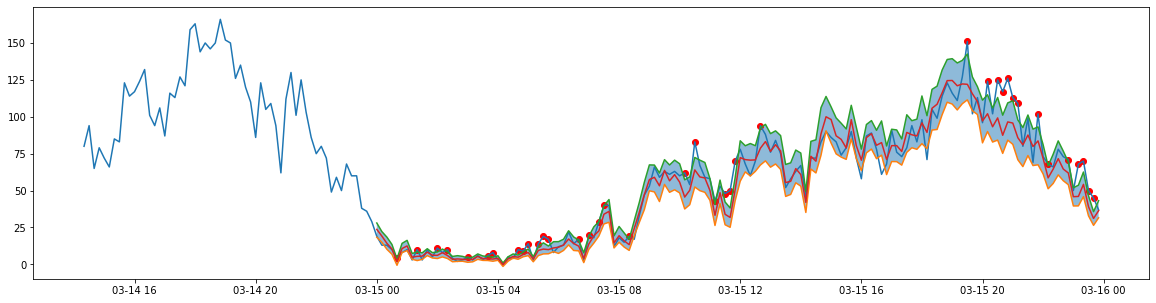

In [24]:
anomalies = full_data['2012-03-15 00:00:00':][full_data['2012-03-15 00:00:00':].values-prediction['0.9'].values > 0]

plt.figure(figsize=(20,5))
plt.plot(full_data['2012-03-14 14:20:00':])
plt.plot(prediction)
plt.fill_between(prediction.index, prediction['0.9'],prediction['0.1'], alpha=0.5)
plt.scatter(anomalies.index, anomalies.values, color='red')

plt.show()

We will compare the original training data in same time period again with predicted results that are changed time intervals as 2H.

In [25]:
resample_prediction = prediction.resample('2H').sum()
resample_full_data = full_data['2012-03-13 23:20:00':].resample('2H').sum()

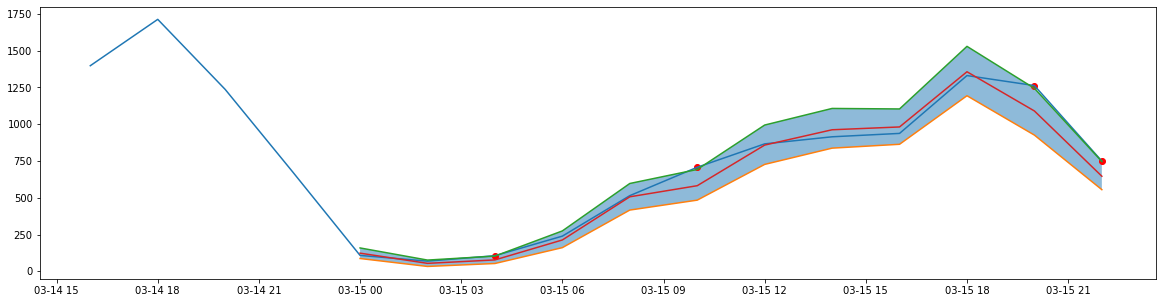

In [26]:
resample_anomalies = resample_full_data['2012-03-15 00:00:00':][resample_full_data['2012-03-15 00:00:00':].values-resample_prediction['0.9'].values > 0]

plt.figure(figsize=(20,5))
plt.plot(resample_full_data['2012-03-14 14:20:00':])
plt.plot(resample_prediction)
plt.fill_between(resample_prediction.index, resample_prediction['0.9'],resample_prediction['0.1'], alpha=0.5)
plt.scatter(resample_anomalies.index, resample_anomalies.values, color='red')

plt.show()

## Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable endpoint_name, and select "Delete" from the "Actions" dropdown menu.

In [27]:
sagemaker.Session().delete_endpoint(predictor.endpoint)